In [1]:
import math
import torch
import matplotlib.pyplot as plt

## Regularization

It is possible to build a model that represents the training dataperfectly. If a predictive or discriminatory function is desired, the desired model must represent the future, unknown data accurately.
Regularization is the process that simplifies a model, to allow it to more accurately describe the entire model.
Some techniques to regularize the model:

- penalize large weights (&theta;s) in the model: weights contribute to the the loss function
- discard a fraction of the learned model periodically

Define some parameters to create a noisy stright line. The regressions will find a best fit line for this. Then define a means to get n random X & Y values, which lie along the noisy line.

In [2]:
m = 3
c = 1

noisiness = 10
num_points = 5

def get_next_batch( batch_size ) :
    x = ( torch.rand( batch_size, 1 ) - 0.5 ) * 10
    y = ( ( torch.rand( batch_size, 1 ) - 0.5 ) * noisiness ) + ( x * m + c )
    return x, y

Expand the x data to a 5th order polynomial, use linear regression to fit that data. Because num_points is 5 and a 5th order polynomial will perfectly describe the data.

In [3]:
x,y = get_next_batch( num_points)

x2 = x * x
x3 = x2 * x
x4 = x3 * x
x5 = x4 * x

x2plusone = torch.cat( ( torch.ones( x.size(0),1 ), x, x2, x3, x4, x5 ) , 1 ) 
R2, _ = torch.gels( y, x2plusone )
R2 = R2[0:x2plusone.size(1)]  

Draw the curve, the training data (red) matches the curve perfectly. A different data set (green) drawn from the same distribution is a less good fit. Note how the simpler model ( a straight line ) would describe both data sets better.

This is an example of overfitting, the model becomes a memory of the training data instead of a generic representation.

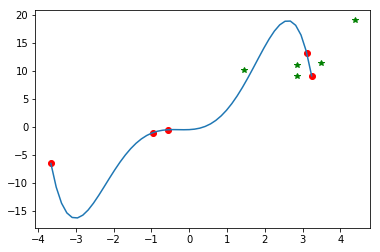

In [4]:
x_test,y_test = get_next_batch( num_points)

plt.scatter( x.tolist(), y.tolist(), color='red' )
plt.plot( x_test.tolist(), y_test.tolist(), 'g*' )

l = torch.linspace( x.min(), x.max(), steps=50 ).unsqueeze(1)
l2 = l * l
l3 = l2 * l
l4 = l3 * l
l5 = l4 * l

l = torch.cat ( ( torch.ones( l.size(0),1 ), l, l2, l3, l4, l5), 1 ) 
yl = l.mm( R2 )

plt.plot( l[:,1].tolist(), yl.tolist() )
plt.show()


There's not much opportunity in the direct linear regression to simplify the model, other than reducing the polynomial order.

Considering the case of the gradient based models, regularization is a feature of the optimizeer. In pytorch the weight_decay parameter defines the cost of model complexity.

Define two models, with and without the regularization feature.

In [5]:
linear1 = torch.nn.Linear( 5, 1, bias=True )
criterion1 = torch.nn.MSELoss()
optimizer1 = torch.optim.Adam( linear1.parameters(), 
                            lr=1e-6, weight_decay=0 )

linear2 = torch.nn.Linear( 5, 1, bias=True )
criterion2 = torch.nn.MSELoss()
optimizer2 = torch.optim.Adam( linear2.parameters(), 
                            lr=1e-6, weight_decay=.30 )

In [6]:
for epoch in range( 1000 ):    
    x_batch, y_batch = get_next_batch( num_points * 50 )

    xb2 = x_batch * x_batch
    xb3 = xb2 * x_batch
    xb4 = xb3 * x_batch
    xb5 = xb4 * x_batch

    X = torch.cat( ( x_batch, xb2, xb3, xb4, xb5 ) , 1 ) 

    optimizer1.zero_grad()
    linear_outputs = linear1( X )
    loss1 = criterion1(linear_outputs, y_batch)
    loss1.backward()
    optimizer1.step()
    
    optimizer2.zero_grad()
    linear_outputs = linear2( X )
    loss2 = criterion2(linear_outputs, y_batch)
    loss2.backward()
    optimizer2.step()

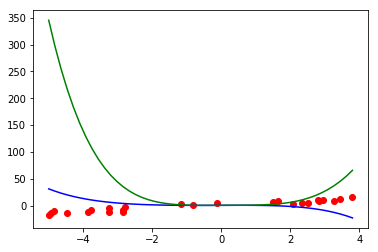

In [7]:
( x, y ) = get_next_batch( num_points*5 )

plt.figure()

plt.scatter( x.tolist(), y.tolist(), color='red' )

l = torch.linspace( x.min(), x.max(), steps=50 ).unsqueeze(1)
l2 = l * l
l3 = l2 * l
l4 = l3 * l
l5 = l4 * l

L = torch.cat ( ( l, l2, l3, l4, l5), 1 ) 

yl1 = linear1( L )
yl2 = linear2( L )

plt.plot( l.tolist(), yl1.tolist(), color='blue' )
plt.plot( l.tolist(), yl2.tolist(), color='green' )

plt.show()